In [9]:
import tensorflow as tf

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [14]:
import os
import imageio

import matplotlib.pyplot as plt

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path + i for i in image_list]
mask_list = [mask_path + i for i in mask_list]

Text(0.5, 1.0, 'Segmentation')

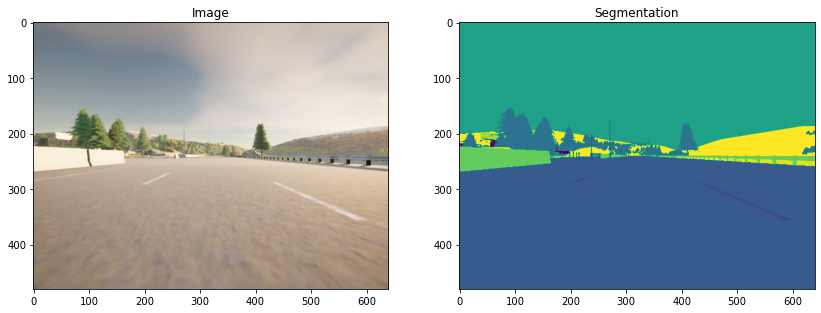

In [15]:
# check out some masked and unmasked images from the data

N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
# mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [16]:
# split the data into masked and unmasked

image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000028.png'>)


In [17]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/000026.png', shape=(), dtype=string)


In [18]:
# preprocess data
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask


def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask


image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

## Structure of the Model

<img src="images/unet.png" width="1000">

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3x3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2x2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used.

In [19]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    convolutional downsampling block
    
    arguments:
        inputs -- input tensor
        n_filters -- number of filters for the convolutional layers
        dropout_prob -- dropout probability
        max_pooling -- use MaxPooling2D to reduce the spatial dimensions of the output volume

    returns:
        next_layer, skip_connection --  next layer and skip connection outputs
    """

    conv = Conv2D(
        n_filters,
        3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal"
    )(inputs)
    conv = Conv2D(
        n_filters,
        3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal"
    )(conv)

    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2, 2))(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [20]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    convolutional upsampling block
    
    arguments:
        expansive_input -- input tensor from previous layer
        contractive_input -- input tensor from previous skip layer
        n_filters -- number of filters for the convolutional layers

    returns:
        conv -- tensor output
    """

    up = Conv2DTranspose(
        n_filters,
        3,
        strides=2,
        padding="same"
    )(expansive_input)

    # merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(
        n_filters,
        3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal"
    )(merge)
    conv = Conv2D(
        n_filters,
        3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal"
    )(conv)

    return conv

In [21]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    UNET model
    
    arguments:
        input_size -- input shape
        n_filters -- number of filters for the convolutional layers
        n_classes -- number of output classes

    returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)

    # contracting path (encoding) #
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2 * n_filters)
    cblock3 = conv_block(cblock2[0], 4 * n_filters)
    cblock4 = conv_block(cblock3[0], 8 * n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], 16 * n_filters, dropout_prob=0.3, max_pooling=None)

    # expanding path (decoding) #
    ublock6 = upsampling_block(cblock5[0], cblock4[1], 8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1], 4 * n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1], 2 * n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(
        n_filters,
        3,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal'
    )(ublock9)
    conv10 = Conv2D(n_classes, 1, padding="same")(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [22]:
# set model dimensions

img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [23]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [24]:
unet.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [25]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


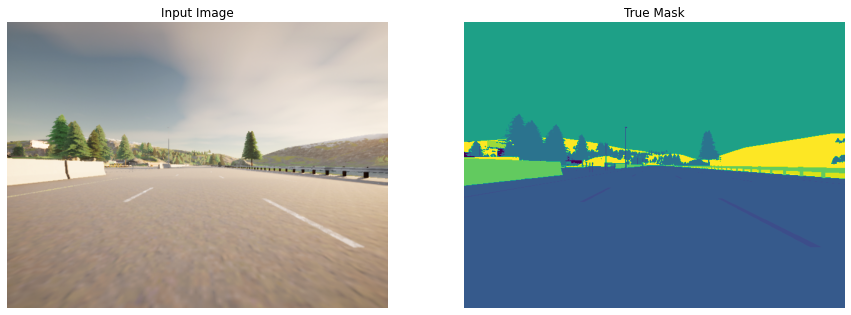

In [26]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


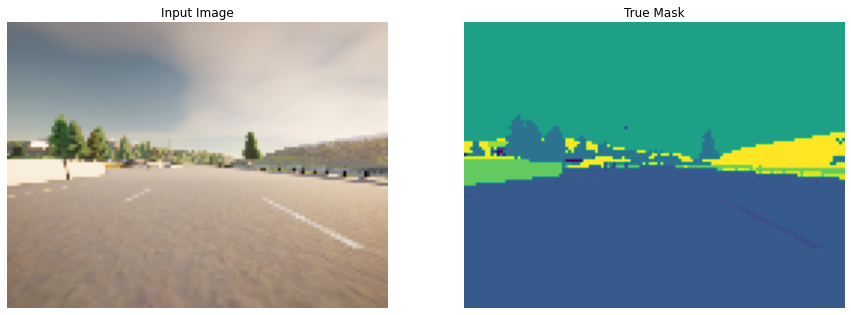

In [27]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [28]:
# train the model

EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 110s 3s/step - loss: 2.1015 - accuracy: 0.5398
Epoch 2/40
34/34 [==============================] - 102s 3s/step - loss: 0.7620 - accuracy: 0.7968
Epoch 3/40
34/34 [==============================] - 101s 3s/step - loss: 0.5779 - accuracy: 0.8330
Epoch 4/40
34/34 [==============================] - 103s 3s/step - loss: 0.4957 - accuracy: 0.8523
Epoch 5/40
34/34 [==============================] - 100s 3s/step - loss: 0.4325 - accuracy: 0.8701
Epoch 6/40
34/34 [==============================] - 101s 3s/step - loss: 0.4017 - accuracy: 0.8783
Epoch 7/40
34/34 [==============================] - 101s 3s/step - loss: 0.3426 - accuracy: 0.8962
Epoch 8/40
34/34 [==============================] - 100s 3s/step - loss: 0.3344 - accuracy: 0.9000
Epoch 9/40
34/34 [==============================] - 100s 3s/step - loss: 0.2872 - accur

In [29]:
# create predicted masks

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

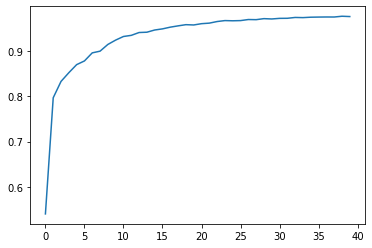

In [30]:
plt.plot(model_history.history["accuracy"])
plt.show()

In [31]:
def show_predictions(dataset=None, num=1):
    """
    displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

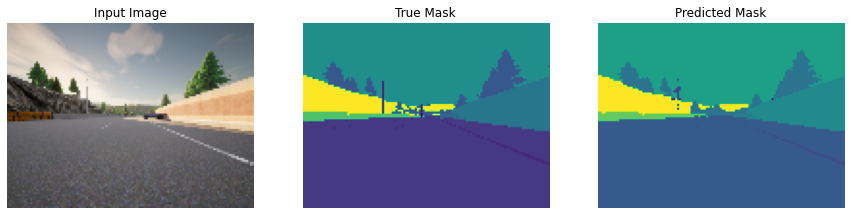

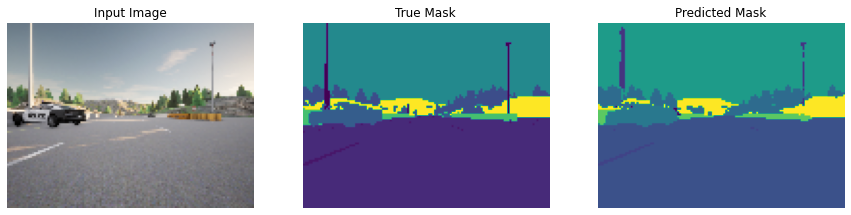

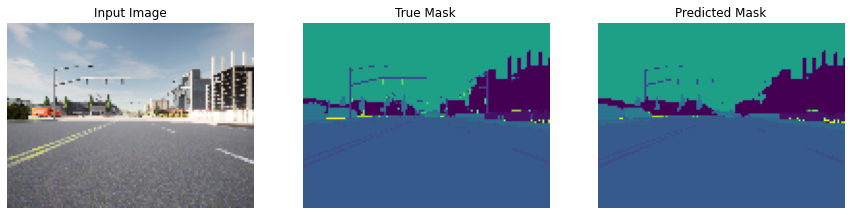

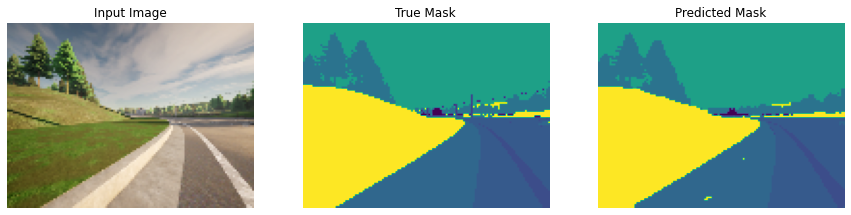

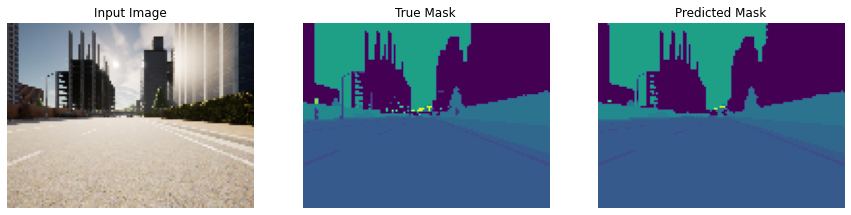

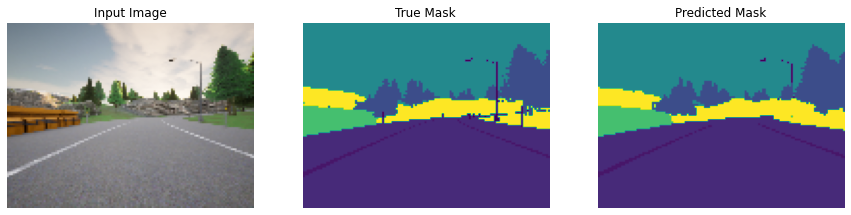

In [32]:
# compare the true masks to the predicted masks, the results are good

show_predictions(train_dataset, 6)

## Summary

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net